In [2]:
### import
from pyhive import presto  
import pandas as pd
import datetime
import numpy as np
from tqdm.autonotebook import tqdm
import pickle
import json
from flask import Flask, jsonify, request
import time
from sqlalchemy import create_engine
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
from IPython.display import clear_output
from threading import Thread, Lock

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [17]:
#Data shared by Amit and Pranav for India OTA
#Tag classification
data = pd.read_csv("india_ota_data.csv",encoding = "ISO-8859-1")

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (5,7,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
data.columns = ['Timestamp','Email_Address','Review_Date','Booking_ID','Review_Source','Hotel_ID','OYO_Name','Review_Score','Review_Comment','No_Review','Breakfast','L2_[Row_1]','AC','L2_[Row_1]','Staff_and_Service','L2_[Row_1]','WiFi','L2_[Row_1]','Room_Linen_Cleanliness','L2_[Row_1]','Washroom','L2_[Row_1]','TV','L2_[Row_1]','Toiletry_Kit','L2_[Row_1]','Checkin_experience','L2_[Row_1]','Directions','L2_[Row_1]','Meal_Experience','L2_[Row_1]','Issue_not_mentioned_here_(L2)','Guest_Name','Response','Issue_Categorization_1','Issue_Categorization_2','Month','M1','M2']

In [19]:
data.columns

Index(['Timestamp', 'Email_Address', 'Review_Date', 'Booking_ID',
       'Review_Source', 'Hotel_ID', 'OYO_Name', 'Review_Score',
       'Review_Comment', 'No_Review', 'Breakfast', 'L2_[Row_1]', 'AC',
       'L2_[Row_1]', 'Staff_and_Service', 'L2_[Row_1]', 'WiFi', 'L2_[Row_1]',
       'Room_Linen_Cleanliness', 'L2_[Row_1]', 'Washroom', 'L2_[Row_1]', 'TV',
       'L2_[Row_1]', 'Toiletry_Kit', 'L2_[Row_1]', 'Checkin_experience',
       'L2_[Row_1]', 'Directions', 'L2_[Row_1]', 'Meal_Experience',
       'L2_[Row_1]', 'Issue_not_mentioned_here_(L2)', 'Guest_Name', 'Response',
       'Issue_Categorization_1', 'Issue_Categorization_2', 'Month', 'M1',
       'M2'],
      dtype='object')

In [20]:
data = data.iloc[:, [8,10,12,14,16,18,20,22,24,26,28,30,34]]

In [21]:
data.columns

Index(['Review_Comment', 'Breakfast', 'AC', 'Staff_and_Service', 'WiFi',
       'Room_Linen_Cleanliness', 'Washroom', 'TV', 'Toiletry_Kit',
       'Checkin_experience', 'Directions', 'Meal_Experience', 'Response'],
      dtype='object')

In [22]:
data.dropna(subset=['Breakfast', 'AC', 'Staff_and_Service', 'WiFi',
       'Room_Linen_Cleanliness', 'Washroom', 'TV', 'Toiletry_Kit',
       'Checkin_experience', 'Directions', 'Meal_Experience'], how='all', inplace=True)

In [23]:
data

,Review_Comment,Breakfast,AC,Staff_and_Service,WiFi,Room_Linen_Cleanliness,Washroom,TV,Toiletry_Kit,Checkin_experience,Directions,Meal_Experience,Response
0,Bedding need to change after every check out.,NaN,NaN,NaN,NaN,Room/Linen Cleanliness,NaN,NaN,NaN,NaN,NaN,NaN,"Apologies for the inconvenience caused, Ravind..."
1,Very much budget-friendly property and very go...,NaN,NaN,Staff and Service,NaN,Room/Linen Cleanliness,NaN,NaN,NaN,NaN,NaN,NaN,"Apologies for the inconvenience caused, Rakesh..."
6,Nice hotel but room is congested. No exhausted...,NaN,NaN,NaN,NaN,Room/Linen Cleanliness,Washroom,NaN,NaN,NaN,NaN,NaN,"Apologies for the inconvenience caused, Rajiv!..."
8,This looks like lodge and cleanliness was huge...,NaN,NaN,NaN,NaN,Room/Linen Cleanliness,NaN,NaN,NaN,NaN,NaN,NaN,"We are sorry to hear this experience, Mayur! R..."
9,I stayed for 2 days with family. One room was ...,NaN,AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Apologies for the inconvenience caused, Ramakr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59096,There are mice insects bed is not there no ...,NaN,NaN,NaN,NaN,Room/Linen Cleanliness,NaN,NaN,NaN,NaN,NaN,NaN,Regret for the unpleasant experience you had w...
59103,The stay wasn't so great and the air condition...,NaN,AC,Staff and Service,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,We are extremely sorry for the unpleasant expe...
59110,nice place workers are good pretty bad in cle...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meal Experience,"Hi, Abhishek! We are extremely apologetic for ..."
59113,Staff is extremely rude they will keep asking...,NaN,NaN,Staff and Service,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,We are extremely sorry for the unpleasant expe...


In [24]:
df = data[['Breakfast', 'AC', 'Staff_and_Service', 'WiFi',
       'Room_Linen_Cleanliness', 'Washroom', 'TV', 'Toiletry_Kit',
       'Checkin_experience', 'Directions', 'Meal_Experience']]

In [25]:
#data = data.replace(np.nan, 0)
df = (df.notnull()).astype('bool').astype('int')

In [26]:
df

,Breakfast,AC,Staff_and_Service,WiFi,Room_Linen_Cleanliness,Washroom,TV,Toiletry_Kit,Checkin_experience,Directions,Meal_Experience
0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,0
6,0,0,0,0,1,1,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
59096,0,0,0,0,1,0,0,0,0,0,0
59103,0,1,1,0,0,0,0,0,0,0,0
59110,0,0,0,0,0,0,0,0,0,0,1
59113,0,0,1,0,0,0,0,0,0,0,0


In [27]:
df['review'] = data['Review_Comment']

In [28]:
df['response'] = data['Response']

In [29]:
df

,Breakfast,AC,Staff_and_Service,WiFi,Room_Linen_Cleanliness,Washroom,TV,Toiletry_Kit,Checkin_experience,Directions,Meal_Experience,review,response
0,0,0,0,0,1,0,0,0,0,0,0,Bedding need to change after every check out.,"Apologies for the inconvenience caused, Ravind..."
1,0,0,1,0,1,0,0,0,0,0,0,Very much budget-friendly property and very go...,"Apologies for the inconvenience caused, Rakesh..."
6,0,0,0,0,1,1,0,0,0,0,0,Nice hotel but room is congested. No exhausted...,"Apologies for the inconvenience caused, Rajiv!..."
8,0,0,0,0,1,0,0,0,0,0,0,This looks like lodge and cleanliness was huge...,"We are sorry to hear this experience, Mayur! R..."
9,0,1,0,0,0,0,0,0,0,0,0,I stayed for 2 days with family. One room was ...,"Apologies for the inconvenience caused, Ramakr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59096,0,0,0,0,1,0,0,0,0,0,0,There are mice insects bed is not there no ...,Regret for the unpleasant experience you had w...
59103,0,1,1,0,0,0,0,0,0,0,0,The stay wasn't so great and the air condition...,We are extremely sorry for the unpleasant expe...
59110,0,0,0,0,0,0,0,0,0,0,1,nice place workers are good pretty bad in cle...,"Hi, Abhishek! We are extremely apologetic for ..."
59113,0,0,1,0,0,0,0,0,0,0,0,Staff is extremely rude they will keep asking...,We are extremely sorry for the unpleasant expe...


In [30]:
'''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
import string
import pandas as pd
import re
import string
import langid

def clean_text_round1(text,punctuation):
    #print(text)
    text = text.lower()
    text = re.sub('[%s]' % re.escape(punctuation), ' ', text)
    text = re.sub('\n',' ',text)
    text = " ".join(text.split())
    return text

punctuation = string.punctuation.replace("'","")
punctuation = punctuation + "0123456789"
df.review = df.review.astype(str)
df['clean_review'] = df['review'].apply(lambda x: clean_text_round1(x,punctuation))
df['langid'] = df['review'].apply(lambda x: langid.classify(x)[0])


In [31]:
df

,Breakfast,AC,Staff_and_Service,WiFi,Room_Linen_Cleanliness,Washroom,TV,Toiletry_Kit,Checkin_experience,Directions,Meal_Experience,review,response,clean_review,langid
0,0,0,0,0,1,0,0,0,0,0,0,Bedding need to change after every check out.,"Apologies for the inconvenience caused, Ravind...",bedding need to change after every check out,en
1,0,0,1,0,1,0,0,0,0,0,0,Very much budget-friendly property and very go...,"Apologies for the inconvenience caused, Rakesh...",very much budget friendly property and very go...,en
6,0,0,0,0,1,1,0,0,0,0,0,Nice hotel but room is congested. No exhausted...,"Apologies for the inconvenience caused, Rajiv!...",nice hotel but room is congested no exhausted ...,en
8,0,0,0,0,1,0,0,0,0,0,0,This looks like lodge and cleanliness was huge...,"We are sorry to hear this experience, Mayur! R...",this looks like lodge and cleanliness was huge...,en
9,0,1,0,0,0,0,0,0,0,0,0,I stayed for 2 days with family. One room was ...,"Apologies for the inconvenience caused, Ramakr...",i stayed for days with family one room was goo...,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59096,0,0,0,0,1,0,0,0,0,0,0,There are mice insects bed is not there no ...,Regret for the unpleasant experience you had w...,there are mice insects bed is not there no cle...,en
59103,0,1,1,0,0,0,0,0,0,0,0,The stay wasn't so great and the air condition...,We are extremely sorry for the unpleasant expe...,the stay wasn't so great and the air condition...,en
59110,0,0,0,0,0,0,0,0,0,0,1,nice place workers are good pretty bad in cle...,"Hi, Abhishek! We are extremely apologetic for ...",nice place workers are good pretty bad in clea...,en
59113,0,0,1,0,0,0,0,0,0,0,0,Staff is extremely rude they will keep asking...,We are extremely sorry for the unpleasant expe...,staff is extremely rude they will keep asking ...,en


In [32]:
# from itertools import islice
# import pkg_resources
# from symspellpy import SymSpell, Verbosity
# import csv
# import string
# import emoji
# import pandas as pd

# def extract_emojis(text):
#     return ''.join(c for c in text if c in emoji.UNICODE_EMOJI)

# sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
# dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765_modified.txt")
# sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1,  encoding="utf-8")
# corrected_list = []
df = df.drop(df[df['langid'] !='en'].index)
# df['emo'] = df['clean_review'].apply(lambda x: extract_emojis(x))
# # save distance too later on, Also fix when list is null
# df['clean_review_autocorrect'] = df['clean_review'].apply(lambda x: sym_spell.lookup_compound(x, max_edit_distance=2)[0].term)


In [33]:
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
#nltk.download('averaged_perceptron_tagger')

stop = stopwords.words('english')
print(stop)
dir(nltk.corpus)

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

    
def clean_text_round2(text):
    # print(text)
    text = text.split(" ")
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    # print(text)
    pos_tags = pos_tag(text)
    #print(pos_tags)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)     

df['lemmatized_review'] = df['clean_review'].apply(lambda x: clean_text_round2(x))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [490]:
df

,Breakfast,AC,Staff_and_Service,WiFi,Room_Linen_Cleanliness,Washroom,TV,Toiletry_Kit,Checkin_experience,Directions,Meal_Experience,review,response,clean_review,langid,lemmatized_review
0,0,0,0,0,1,0,0,0,0,0,0,Bedding need to change after every check out.,"Apologies for the inconvenience caused, Ravind...",bedding need to change after every check out,en,bed need change every check
1,0,0,1,0,1,0,0,0,0,0,0,Very much budget-friendly property and very go...,"Apologies for the inconvenience caused, Rakesh...",very much budget friendly property and very go...,en,much budget friendly property good short time ...
6,0,0,0,0,1,1,0,0,0,0,0,Nice hotel but room is congested. No exhausted...,"Apologies for the inconvenience caused, Rajiv!...",nice hotel but room is congested no exhausted ...,en,nice hotel room congest exhausted bathroom saf...
8,0,0,0,0,1,0,0,0,0,0,0,This looks like lodge and cleanliness was huge...,"We are sorry to hear this experience, Mayur! R...",this looks like lodge and cleanliness was huge...,en,look like lodge cleanliness huge issue
9,0,1,0,0,0,0,0,0,0,0,0,I stayed for 2 days with family. One room was ...,"Apologies for the inconvenience caused, Ramakr...",i stayed for days with family one room was goo...,en,stayed day family one room good another room g...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59096,0,0,0,0,1,0,0,0,0,0,0,There are mice insects bed is not there no ...,Regret for the unpleasant experience you had w...,there are mice insects bed is not there no cle...,en,mouse insect bed cleaning room good
59103,0,1,1,0,0,0,0,0,0,0,0,The stay wasn't so great and the air condition...,We are extremely sorry for the unpleasant expe...,the stay wasn't so great and the air condition...,en,stay great air conditioner always leak due flo...
59110,0,0,0,0,0,0,0,0,0,0,1,nice place workers are good pretty bad in cle...,"Hi, Abhishek! We are extremely apologetic for ...",nice place workers are good pretty bad in clea...,en,nice place worker good pretty bad clean staff ...
59113,0,0,1,0,0,0,0,0,0,0,0,Staff is extremely rude they will keep asking...,We are extremely sorry for the unpleasant expe...,staff is extremely rude they will keep asking ...,en,staff extremely rude keep ask money stay thief...


In [491]:
df.sum()

Breakfast                                                              4121
AC                                                                     1387
Staff_and_Service                                                     10237
WiFi                                                                    897
Room_Linen_Cleanliness                                                12604
Washroom                                                               8702
TV                                                                     2397
Toiletry_Kit                                                            684
Checkin_experience                                                     2157
Directions                                                             1873
Meal_Experience                                                        1169
review                    Bedding need to change after every check out.V...
clean_review              bedding need to change after every check outve...
langid      

In [281]:
df.to_csv('lemma_reviews.csv')

In [492]:
#Shared by Himanshu Makkar, Nagendra
df2 = pd.read_excel("3PostLemmatization.xlsx")

In [493]:
df2 = df2[['Breakfast','AC','Staff & Service', 'Wifi','Room','Hygiene','Washroom', 'TV','Check-in/Check-out','Direction','Food','comment3lemmatize']]

In [494]:
df2

,Breakfast,AC,Staff & Service,Wifi,Room,Hygiene,Washroom,TV,Check-in/Check-out,Direction,Food,comment3lemmatize
0,False,False,True,False,False,False,False,False,False,False,False,great stay hotel staff supportive kind hearted...
1,False,False,False,False,False,False,False,False,False,True,False,worst ever oyo experienced oyo sign board map ...
2,False,False,False,False,False,False,False,False,False,False,False,one best property ever would like visit strong...
3,False,False,True,False,False,False,False,False,False,False,False,everything good complaint staff behaviour poli...
4,False,False,True,False,True,True,False,False,False,False,False,one best hotel oyo recommend hotel guest room ...
...,...,...,...,...,...,...,...,...,...,...,...,...
2368,False,False,False,False,False,False,False,False,False,False,False,curtain thin incapable keep sunlight away cann...
2369,False,False,False,False,False,False,False,False,False,False,False,local id card accept unmarried couple welcome ...
2370,False,False,False,False,True,True,True,False,False,False,False,wash room clean room clean properly corner dir...
2371,False,False,True,False,False,False,False,False,False,False,False,manager tall height tell leave hotel complain ...


In [495]:
df2[['Breakfast','AC','Staff & Service', 'Wifi','Room','Hygiene','Washroom', 'TV','Check-in/Check-out','Direction','Food']] *= 1

In [496]:
df2

,Breakfast,AC,Staff & Service,Wifi,Room,Hygiene,Washroom,TV,Check-in/Check-out,Direction,Food,comment3lemmatize
0,0,0,1,0,0,0,0,0,0,0,0,great stay hotel staff supportive kind hearted...
1,0,0,0,0,0,0,0,0,0,1,0,worst ever oyo experienced oyo sign board map ...
2,0,0,0,0,0,0,0,0,0,0,0,one best property ever would like visit strong...
3,0,0,1,0,0,0,0,0,0,0,0,everything good complaint staff behaviour poli...
4,0,0,1,0,1,1,0,0,0,0,0,one best hotel oyo recommend hotel guest room ...
...,...,...,...,...,...,...,...,...,...,...,...,...
2368,0,0,0,0,0,0,0,0,0,0,0,curtain thin incapable keep sunlight away cann...
2369,0,0,0,0,0,0,0,0,0,0,0,local id card accept unmarried couple welcome ...
2370,0,0,0,0,1,1,1,0,0,0,0,wash room clean room clean properly corner dir...
2371,0,0,1,0,0,0,0,0,0,0,0,manager tall height tell leave hotel complain ...


In [497]:
#Room and hygiene should be merged
df2['Room_and_hygiene'] = df2.apply(lambda x: x.Room or x.Hygiene, axis = 1) 

In [498]:
df2.drop(['Room','Hygiene'], inplace = True, axis = 1)

In [499]:
df2

,Breakfast,AC,Staff & Service,Wifi,Washroom,TV,Check-in/Check-out,Direction,Food,comment3lemmatize,Room_and_hygiene
0,0,0,1,0,0,0,0,0,0,great stay hotel staff supportive kind hearted...,0
1,0,0,0,0,0,0,0,1,0,worst ever oyo experienced oyo sign board map ...,0
2,0,0,0,0,0,0,0,0,0,one best property ever would like visit strong...,0
3,0,0,1,0,0,0,0,0,0,everything good complaint staff behaviour poli...,0
4,0,0,1,0,0,0,0,0,0,one best hotel oyo recommend hotel guest room ...,1
...,...,...,...,...,...,...,...,...,...,...,...
2368,0,0,0,0,0,0,0,0,0,curtain thin incapable keep sunlight away cann...,0
2369,0,0,0,0,0,0,0,0,0,local id card accept unmarried couple welcome ...,0
2370,0,0,0,0,1,0,0,0,0,wash room clean room clean properly corner dir...,1
2371,0,0,1,0,0,0,0,0,0,manager tall height tell leave hotel complain ...,0


In [500]:
df2.columns = ['Breakfast', 'AC', 'Staff_and_Service', 'WiFi','Washroom', 'TV',
       'Checkin_experience', 'Directions', 'Meal_Experience','lemmatized_review','Room_Linen_Cleanliness']

In [501]:
df2

,Breakfast,AC,Staff_and_Service,WiFi,Washroom,TV,Checkin_experience,Directions,Meal_Experience,lemmatized_review,Room_Linen_Cleanliness
0,0,0,1,0,0,0,0,0,0,great stay hotel staff supportive kind hearted...,0
1,0,0,0,0,0,0,0,1,0,worst ever oyo experienced oyo sign board map ...,0
2,0,0,0,0,0,0,0,0,0,one best property ever would like visit strong...,0
3,0,0,1,0,0,0,0,0,0,everything good complaint staff behaviour poli...,0
4,0,0,1,0,0,0,0,0,0,one best hotel oyo recommend hotel guest room ...,1
...,...,...,...,...,...,...,...,...,...,...,...
2368,0,0,0,0,0,0,0,0,0,curtain thin incapable keep sunlight away cann...,0
2369,0,0,0,0,0,0,0,0,0,local id card accept unmarried couple welcome ...,0
2370,0,0,0,0,1,0,0,0,0,wash room clean room clean properly corner dir...,1
2371,0,0,1,0,0,0,0,0,0,manager tall height tell leave hotel complain ...,0


In [502]:
df = df.append(df2, ignore_index = True)

/usr/local/lib64/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [503]:
df

,AC,Breakfast,Checkin_experience,Directions,Meal_Experience,Room_Linen_Cleanliness,Staff_and_Service,TV,Toiletry_Kit,Washroom,WiFi,clean_review,langid,lemmatized_review,response,review
0,0,0,0,0,0,1,0,0,0.0,0,0,bedding need to change after every check out,en,bed need change every check,"Apologies for the inconvenience caused, Ravind...",Bedding need to change after every check out.
1,0,0,0,0,0,1,1,0,0.0,0,0,very much budget friendly property and very go...,en,much budget friendly property good short time ...,"Apologies for the inconvenience caused, Rakesh...",Very much budget-friendly property and very go...
2,0,0,0,0,0,1,0,0,0.0,1,0,nice hotel but room is congested no exhausted ...,en,nice hotel room congest exhausted bathroom saf...,"Apologies for the inconvenience caused, Rajiv!...",Nice hotel but room is congested. No exhausted...
3,0,0,0,0,0,1,0,0,0.0,0,0,this looks like lodge and cleanliness was huge...,en,look like lodge cleanliness huge issue,"We are sorry to hear this experience, Mayur! R...",This looks like lodge and cleanliness was huge...
4,1,0,0,0,0,0,0,0,0.0,0,0,i stayed for days with family one room was goo...,en,stayed day family one room good another room g...,"Apologies for the inconvenience caused, Ramakr...",I stayed for 2 days with family. One room was ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32121,0,0,0,0,0,0,0,0,NaN,0,0,NaN,NaN,curtain thin incapable keep sunlight away cann...,NaN,NaN
32122,0,0,0,0,0,0,0,0,NaN,0,0,NaN,NaN,local id card accept unmarried couple welcome ...,NaN,NaN
32123,0,0,0,0,0,1,0,0,NaN,1,0,NaN,NaN,wash room clean room clean properly corner dir...,NaN,NaN
32124,0,0,0,0,0,0,1,0,NaN,0,0,NaN,NaN,manager tall height tell leave hotel complain ...,NaN,NaN


In [504]:
df.fillna(0, inplace = True)

In [73]:
df.columns

Index(['Timestamp', 'Email Address', 'Review Date', 'Hotel ID',
       'Reference ID / Booking ID', 'OYO Name ', 'L1', 'L2 [Row 1]', 'L1.1',
       'L2 [Row 1].1', 'L1.2', 'L2 [Row 1].2', 'L1.3', 'L2 [Row 1].3', 'L1.4',
       'L2 [Row 1].4', 'L1.5', 'L2 [Row 1].5', 'L1.6', 'L2 [Row 1].6', 'L1.7',
       'L2 [Row 1].7', 'L1.8', 'L2 [Row 1].8', 'L1.9', 'L2 [Row 1].9', 'Other',
       'No Review', 'Any Suggestions', 'Review Source ', 'Review Score',
       'Review Comment', 'Review Response Given', 'Country',
       'Issue Categorization/ Related'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

categories = ['Breakfast', 'AC', 'Staff_and_Service', 'WiFi',
       'Room_Linen_Cleanliness', 'Washroom', 'TV', 'Toiletry_Kit',
       'Checkin_experience', 'Directions', 'Meal_Experience']
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)
X_train = train.lemmatized_review
X_test = test.lemmatized_review
y_train = train.Room_Linen_Cleanliness
y_test = test.Room_Linen_Cleanliness

In [150]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing Breakfast
Test accuracy is 0.8657704450555046
... Processing AC
Test accuracy is 0.9532538955087076
... Processing Staff and Service
Test accuracy is 0.7521132498217741
... Processing WiFi
Test accuracy is 0.9694469905285671
... Processing Room/Linen Cleanliness
Test accuracy is 0.7650473571646808
... Processing Washroom
Test accuracy is 0.7810367654547307
... Processing TV
Test accuracy is 0.922089825847846
... Processing Toiletry Kit
Test accuracy is 0.9753539056930441
... Processing Check-in experience
Test accuracy is 0.9286078012017517
... Processing Directions
Test accuracy is 0.9388939810571342
... Processing Meal Experience
Test accuracy is 0.9593644974029942


In [151]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing Breakfast
Test accuracy is 0.9529483654139933
... Processing AC
Test accuracy is 0.9792239535594256
... Processing Staff and Service
Test accuracy is 0.8444851817904063
... Processing WiFi
Test accuracy is 0.9908340971585701
... Processing Room/Linen Cleanliness
Test accuracy is 0.823199918525308
... Processing Washroom
Test accuracy is 0.8951013341480802
... Processing TV
Test accuracy is 0.9715857011915674
... Processing Toiletry Kit
Test accuracy is 0.9783073632752826
... Processing Check-in experience
Test accuracy is 0.9449027395865159
... Processing Directions
Test accuracy is 0.9569202566452796
... Processing Meal Experience
Test accuracy is 0.9640492921886139


In [152]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing Breakfast
Test accuracy is 0.94989306446685
... Processing AC
Test accuracy is 0.9756594357877584
... Processing Staff and Service
Test accuracy is 0.8529381810775029
... Processing WiFi
Test accuracy is 0.9857419289133313
... Processing Room/Linen Cleanliness
Test accuracy is 0.8302271107037377
... Processing Washroom
Test accuracy is 0.8905183827273653
... Processing TV
Test accuracy is 0.9674101232304715
... Processing Toiletry Kit
Test accuracy is 0.9775944597209492
... Processing Check-in experience
Test accuracy is 0.9474488237091353
... Processing Directions
Test accuracy is 0.9564110398207557
... Processing Meal Experience
Test accuracy is 0.9642529789184234


In [156]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', RandomForestClassifier(max_depth=10, random_state=42, n_estimators = 500, max_leaf_nodes = 20))
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    rf_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = rf_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing Breakfast
Test accuracy is 0.857826662592932
... Processing AC
Test accuracy is 0.9532538955087076
... Processing Staff and Service
Test accuracy is 0.6585191974742846
... Processing WiFi
Test accuracy is 0.9693451471636623
... Processing Room/Linen Cleanliness
Test accuracy is 0.659232101028618
... Processing Washroom
Test accuracy is 0.7100519401161014
... Processing TV
Test accuracy is 0.9198492718199409
... Processing Toiletry Kit
Test accuracy is 0.9753539056930441
... Processing Check-in experience
Test accuracy is 0.9283022711070373
... Processing Directions
Test accuracy is 0.9374681739484673
... Processing Meal Experience
Test accuracy is 0.9593644974029942


In [506]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, random_state=42, test_size=0.30, shuffle=True)
from sklearn.feature_extraction.text import TfidfVectorizer

categories = ['Breakfast', 'AC', 'Staff_and_Service', 'WiFi',
       'Room_Linen_Cleanliness', 'Washroom', 'TV', 'Toiletry_Kit',
       'Checkin_experience', 'Directions', 'Meal_Experience']

vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2), norm='l2')
vectorizer.fit(train.lemmatized_review)
vectorizer.fit(test.lemmatized_review)
x_train = vectorizer.transform(train.lemmatized_review)
y_train = train[['Breakfast', 'AC', 'Staff_and_Service', 'WiFi',
       'Room_Linen_Cleanliness', 'Washroom', 'TV', 'Toiletry_Kit',
       'Checkin_experience', 'Directions', 'Meal_Experience']]
x_test = vectorizer.transform(test.lemmatized_review)
y_test = test[['Breakfast', 'AC', 'Staff_and_Service', 'WiFi',
       'Room_Linen_Cleanliness', 'Washroom', 'TV', 'Toiletry_Kit',
       'Checkin_experience', 'Directions', 'Meal_Experience']]

In [ ]:
# Hyperparamete Tuning
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3,
                        ngram_range=(1, 2))

#print(df.comment3lemmatize)
# We transform each complaint into a vector
fitted_vectorizer = tfidf.fit(X_train)

features = fitted_vectorizer.transform(X_train)

labels = y_train

from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2,250)
fitted_selector = selector.fit(features,y_train)
features_new = fitted_selector.transform(features)

mask = fitted_selector.get_support() #list of booleans
new_features_names = [] # The list of your K best features
feature_names= tfidf.get_feature_names()
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features_names.append(feature)
        
        
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score
from hyperopt import hp, tpe
import xgboost as xgb
from hyperopt.fmin import fmin

auc_scorer = make_scorer(roc_auc_score)

def objective(params):
   
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'min_child_weight': int(params['min_child_weight']),
              'learning_rate' : float(params['learning_rate']),
              'gamma': float(params['gamma']),
              'colsample_bytree': float(params['colsample_bytree']),
              'subsample': float(params['subsample']),
              'colsample_bylevel': float(params['colsample_bylevel'])
#               ,'class_weight':str(params['class_weight'])
             }
   
    clf = xgb.XGBClassifier(random_state=42, **params)
    score = cross_val_score(clf,features_new,labels, scoring=auc_scorer, cv=StratifiedKFold(n_splits=5)).mean()
    print("AUC {:.3f} params {}".format(score, params))
    return -score

space = {
    'learning_rate':    hp.uniform('learning_rate', 0.01, 0.5),
    'max_depth':        hp.choice('max_depth',        np.arange(1, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'gamma' : hp.uniform('gamma', 0.1, 1.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.9),
    'subsample':        hp.uniform('subsample', 0.7, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.3, 0.8),
    'n_estimators':     hp.choice('n_estimators', np.arange(10, 1100, 50, dtype=int)),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100)
for i in best.keys():
    best[i] = int(best[i])

best_model = xgb.XGBClassifier(random_state=42, **best)
#print(best_model)

In [274]:
#Unique words by frequency
from collections import Counter
result = sorted(Counter(" ".join(df['lemmatized_review'].values.tolist()).split(" ")).items(),key=lambda item: item[1], reverse=True)
result

[('room', 26695),
 ('hotel', 17228),
 ('good', 11582),
 ('bad', 9003),
 ('service', 8796),
 ('staff', 7373),
 ('stay', 6271),
 ('clean', 6173),
 ('water', 6042),
 ('breakfast', 6020),
 ('work', 5081),
 ('dirty', 4562),
 ('experience', 4164),
 ('provide', 4157),
 ('book', 4067),
 ('food', 4031),
 ('bathroom', 3910),
 ('also', 3891),
 ('location', 3874),
 ('even', 3680),
 ('poor', 3381),
 ('give', 3306),
 ('small', 3194),
 ('bed', 3112),
 ('check', 3107),
 ('time', 2957),
 ('one', 2894),
 ('tv', 2769),
 ('available', 2754),
 ('get', 2462),
 ('washroom', 2385),
 ('ask', 2312),
 ('hot', 2218),
 ('like', 2030),
 ('towel', 2022),
 ('say', 1968),
 ('day', 1961),
 ('money', 1894),
 ('property', 1869),
 ('ac', 1862),
 ('oyo', 1846),
 ('need', 1833),
 ('reception', 1814),
 ('place', 1810),
 ('pay', 1783),
 ('go', 1743),
 ('night', 1739),
 ('facility', 1724),
 ('overall', 1611),
 ('well', 1525),
 ('quality', 1496),
 ('take', 1495),
 ('ok', 1456),
 ('call', 1449),
 ('come', 1419),
 ('rude', 1398),

In [275]:
len(result)

15280

In [263]:
df['len'] = df.lemmatized_review.apply(len)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c425b1dd8>]],
      dtype=object)

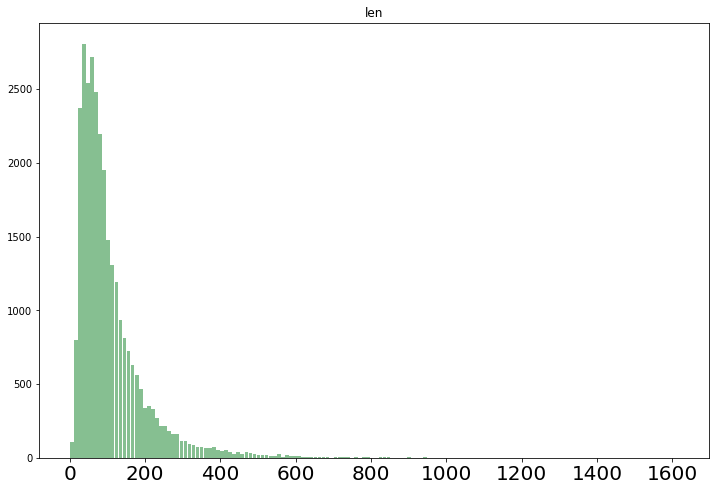

In [272]:
df.hist(column='len',bins=150, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9, xlabelsize=20)

In [507]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import label_ranking_average_precision_score

for category in categories:
    print('**Processing {} comments...**'.format(category))
    xgb_pipeline =  xgb.XGBClassifier(objective='multi:softprob', num_class=11, colsample_bylevel= 0.336632536337104, colsample_bytree= 0.8704338954057144, gamma= 0.980340770131124, 
                                          learning_rate= 0.016699072377003688, max_depth= 100, min_child_weight= 2, n_estimators= 100, 
                                          subsample= 0.7307162652216244, 
                                          scale_pos_weight=(1-np.mean(train[category]))/np.mean(train[category]))
            
    # Training logistic regression model on train data
    xgb_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = xgb_pipeline.predict(x_test)
    #print(prediction.shape)
    pred_probs = xgb_pipeline.predict_proba(x_test)
    #print(pred_probs)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print('{}'.format(classification_report(test[category], prediction)))
    print('ROC_AUC is {}'.format(roc_auc_score(test[category], prediction)))
    print("\n")

**Processing Breakfast comments...**
Test accuracy is 0.9632703880473127
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      8288
           1       0.84      0.91      0.87      1350

    accuracy                           0.96      9638
   macro avg       0.91      0.94      0.93      9638
weighted avg       0.96      0.96      0.96      9638

ROC_AUC is 0.9408186758186758


**Processing AC comments...**
Test accuracy is 0.9838140693089853
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9171
           1       0.83      0.84      0.83       467

    accuracy                           0.98      9638
   macro avg       0.91      0.92      0.91      9638
weighted avg       0.98      0.98      0.98      9638

ROC_AUC is 0.9163002640527107


**Processing Staff_and_Service comments...**
Test accuracy is 0.8568167669641005
              precision    recall  f1-score   support

       

In [360]:
test[category]

28510    0
21883    0
31670    0
6835     0
10305    0
        ..
3689     0
1061     0
10841    0
41       0
28328    0
Name: Breakfast, Length: 9638, dtype: int64

In [278]:
#xgb_pipeline.predict(x_test)

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
#Comparison with RoBERTa

import pandas as pd
from simpletransformers.classification import MultiLabelClassificationModel

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [328]:
model = MultiLabelClassificationModel('roberta', 'roberta-base', num_labels=11, use_cuda=False, args={'train_batch_size':2, 'gradient_accumulation_steps':16, 'learning_rate': 3e-5, 'num_train_epochs': 3, 'max_seq_length': 512})


In [332]:
df['combine'] = df[['AC', 'Breakfast', 'Checkin_experience', 'Directions',
       'Meal_Experience', 'Room_Linen_Cleanliness', 'Staff_and_Service', 'TV',
       'Toiletry_Kit', 'Washroom', 'WiFi']].values.tolist()

In [333]:
df

,AC,Breakfast,Checkin_experience,Directions,Meal_Experience,Room_Linen_Cleanliness,Staff_and_Service,TV,Toiletry_Kit,Washroom,WiFi,clean_review,langid,lemmatized_review,len,response,review,combine
0,0,0,0,0,0,1,0,0,0.0,0,0,bedding need to change after every check out,en,bed need change every check,27.0,"Apologies for the inconvenience caused, Ravind...",Bedding need to change after every check out.,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,0,0,0,0,0,1,1,0,0.0,0,0,very much budget friendly property and very go...,en,much budget friendly property good short time ...,191.0,"Apologies for the inconvenience caused, Rakesh...",Very much budget-friendly property and very go...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
2,0,0,0,0,0,1,0,0,0.0,1,0,nice hotel but room is congested no exhausted ...,en,nice hotel room congest exhausted bathroom saf...,87.0,"Apologies for the inconvenience caused, Rajiv!...",Nice hotel but room is congested. No exhausted...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,0,0,0,0,0,1,0,0,0.0,0,0,this looks like lodge and cleanliness was huge...,en,look like lodge cleanliness huge issue,38.0,"We are sorry to hear this experience, Mayur! R...",This looks like lodge and cleanliness was huge...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,1,0,0,0,0,0,0,0,0.0,0,0,i stayed for days with family one room was goo...,en,stayed day family one room good another room g...,185.0,"Apologies for the inconvenience caused, Ramakr...",I stayed for 2 days with family. One room was ...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32121,0,0,0,0,0,0,0,0,0.0,0,0,0,0,curtain thin incapable keep sunlight away cann...,0.0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
32122,0,0,0,0,0,0,0,0,0.0,0,0,0,0,local id card accept unmarried couple welcome ...,0.0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
32123,0,0,0,0,0,1,0,0,0.0,1,0,0,0,wash room clean room clean properly corner dir...,0.0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
32124,0,0,0,0,0,0,1,0,0.0,0,0,0,0,manager tall height tell leave hotel complain ...,0.0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


In [348]:
df.to_csv('df1.csv')

In [336]:
df3 = df[['lemmatized_review','combine']]


In [337]:
train_df, eval_df = train_test_split(df3, test_size=0.3)

In [338]:
train_df

,lemmatized_review,combine
17252,room good except bathroom staff completely ill...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
29156,horrible experience never stay nasty hotel roo...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
19925,booked hotel stay due poor cleanliness,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
22030,provide tv towel soap,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
12236,happy stay default select hotel felt mistake s...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
...,...,...
28636,seat area room mosquito repellent electricity ...,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
29710,broken lift tv toilet lock soap,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16093,nice room money spend room clean mosquito facu...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
20455,bad experience provide even single dust bin fl...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


In [339]:
model.train_model(train_df)

/usr/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:247: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.147964

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Running loss: 0.204521

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Running loss: 0.151779

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Running loss: 0.469362

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Running loss: 0.034185

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Running loss: 0.042562


Running loss: 0.037875

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Running loss: 0.065036

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Running loss: 0.082528

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [353]:

predictions, raw_outputs = model.predict(["look like lodge cleanliness huge issue.","AC was not working properly."])
print(predictions)
print(raw_outputs)


[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[0.00368435 0.00649923 0.006114   0.00797769 0.00508004 0.9696443
  0.0132347  0.00441982 0.0037427  0.01391388 0.0020036 ]
 [0.9745233  0.04099964 0.0382877  0.0461242  0.04676029 0.08568353
  0.07655318 0.05767137 0.01334269 0.02727816 0.05573319]]


In [377]:
temp = pd.merge(df, eval_df , on='lemmatized_review', how='inner')

In [378]:
temp

,AC,Breakfast,Checkin_experience,Directions,Meal_Experience,Room_Linen_Cleanliness,Staff_and_Service,TV,Toiletry_Kit,Washroom,WiFi,clean_review,langid,lemmatized_review,len,response,review,combine_x,combine_y
0,0,0,0,0,0,1,0,0,0.0,0,0,stay at hotel was good for the described price...,en,stay hotel good described price restaurant mus...,174.0,"Apologies for the inconvenience caused, Manish...",Stay at hotel was good for the described price...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,0,0,0,0,0,0,1,0,0.0,0,0,unhappy with front desk service too much waiti...,en,unhappy front desk service much wait time,41.0,"Apologies for the inconvenience caused, Natara...",Unhappy with front desk service too much wait...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
2,0,0,0,0,0,1,0,0,0.0,0,0,hotel location is good it is nearby raipur rai...,en,hotel location good nearby raipur railway stat...,178.0,We are so disappointed to hear such kind of ex...,Hotel location is good it is nearby Raipur ra...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,0,0,0,0,0,1,0,0,0.0,0,0,good location but room should be more clean a ...,en,good location room clean different smell aroun...,52.0,We are so disappointed to hear such kind of ex...,Good location. But room should be more clean. ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,0,0,0,0,0,1,0,0,0.0,0,0,hotel is near railway station service of the e...,en,hotel near railway station service employee go...,88.0,"We are sorry to hear this experience, Satyendr...",Hotel is near railway Station service of the e...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10277,0,0,0,0,0,0,1,0,0.0,0,0,0,0,staff rude provide room oyo rate charge money ...,0.0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
10278,0,0,0,0,0,0,1,0,0.0,0,0,0,0,pathetic service nothing hotel welcome book co...,0.0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
10279,0,0,0,0,0,1,0,0,0.0,1,0,0,0,water leakage proper attention room time give ...,0.0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
10280,0,0,0,0,0,0,0,0,0.0,0,0,0,0,local id card accept unmarried couple welcome ...,0.0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [406]:
predictions, raw_outputs = model.predict(temp['lemmatized_review'].tolist())
df5 = pd.DataFrame(predictions, columns = ['AC', 'Breakfast', 'Checkin_experience', 'Directions',
       'Meal_Experience', 'Room_Linen_Cleanliness', 'Staff_and_Service', 'TV',
       'Toiletry_Kit', 'Washroom', 'WiFi'])


In [472]:
from sklearn.metrics import roc_auc_score
categories = ['Breakfast', 'AC', 'Staff_and_Service', 'WiFi',
       'Room_Linen_Cleanliness', 'Washroom', 'TV', 'Toiletry_Kit',
       'Checkin_experience', 'Directions', 'Meal_Experience']

for category in categories:
    print('**Processing {} comments...**'.format(category))

    print('Test accuracy is {}'.format(accuracy_score(temp[category], df5[category])))
    print('{}'.format(classification_report(temp[category], df5[category])))
    print('ROC_AUC is {}'.format(roc_auc_score(temp[category], df5[category])))
    print("\n")

**Processing Breakfast comments...**
Test accuracy is 0.9660571873176425
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      8936
           1       0.83      0.94      0.88      1346

    accuracy                           0.97     10282
   macro avg       0.91      0.95      0.93     10282
weighted avg       0.97      0.97      0.97     10282

ROC_AUC is 0.9545998056511484


**Processing AC comments...**
Test accuracy is 0.9835635090449328
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9814
           1       0.77      0.91      0.84       468

    accuracy                           0.98     10282
   macro avg       0.88      0.95      0.91     10282
weighted avg       0.99      0.98      0.98     10282

ROC_AUC is 0.9506927135315152


**Processing Staff_and_Service comments...**
Test accuracy is 0.8865979381443299
              precision    recall  f1-score   support

       

In [55]:
#International Model
#dfs = pd.read_csv('International Review OTA (November 2019) - Form Responses.tsv', sep='\t', error_bad_lines=False)

import pandas as pd
import glob

all_files = glob.glob("data_reviews/*.tsv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, sep='\t', error_bad_lines=False)
    li.append(df)

dfs = pd.concat(li, axis=0, ignore_index=True)

b'Skipping line 19829: expected 34 fields, saw 36\nSkipping line 19889: expected 34 fields, saw 36\nSkipping line 20132: expected 34 fields, saw 36\nSkipping line 20222: expected 34 fields, saw 38\n'
b'Skipping line 45820: expected 34 fields, saw 39\n'
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (27,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
b'Skipping line 29300: expected 34 fields, saw 35\nSkipping line 30842: expected 34 fields, saw 35\n'
b'Skipping line 47791: expected 34 fields, saw 35\n'
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
b'Skipping line 3920: expected 35 fields, saw 36\nSkipping line 4273: expected 35 fields, saw 41\n'
b

In [56]:
dfs

,Any Suggestions,Country,Date,Email Address,Hotel ID,Hotel Name,Issue Categorization/ Related,L1,L1.1,L1.2,...,OYO Name,Other,Reference ID / Booking ID,Response,Review Comment,Review Date,Review Response Given,Review Score,Review Source,Timestamp
0,NaN,Indonesia,NaN,rishabhmahandiya.wv@oyorooms.com,5990187.0,NaN,NaN,NaN,NaN,NaN,...,Collection O 22 Hotel Pasar Baru Heritage,Just parking is difficult,2121076186,NaN,Parkir aja sih yg sulit Overall i like it,12/31/2019,Terima kasih telah memberi peringkat pada kami...,10,Booking.com,1/1/2020 9:54:42
1,NaN,Indonesia,NaN,rishabhmahandiya.wv@oyorooms.com,5928299.0,NaN,NaN,NaN,NaN,NaN,...,OYO 2383 Andongkoe 64 Salatiga,"Access is difficult, the water is difficult",3251593312,NaN,"Aksesnya susah, Air angetnya susah, ada sampah...",12/27/2019,"Hai, Terima kasih banyak atas penilaian positi...",7.5,Booking.com,1/1/2020 9:56:21
2,NaN,Indonesia,NaN,rishabhmahandiya.wv@oyorooms.com,5928283.0,NaN,NaN,NaN,NaN,Comfort & safety,...,OYO 2409 Safara Guesthouse,Limited space for car park,2841799233,NaN,"Limited space for car park, slow breakfast ser...",12/30/2019,"Hi, Heru! Sorry for the trouble faced. We have...",7,Booking.com,1/1/2020 9:59:17
3,NaN,Indonesia,NaN,rishabhmahandiya.wv@oyorooms.com,5913965.0,NaN,NaN,NaN,NaN,NaN,...,OYO 2348 Omah Lasaro Exclusive,NaN,3783301025,NaN,Tidak ada selimut dan tempatnya terlalu masuk ...,12/30/2019,Terima kasih telah memberi peringkat pada kami...,7.5,Booking.com,1/1/2020 10:00:26
4,NaN,Indonesia,NaN,rishabhmahandiya.wv@oyorooms.com,5913952.0,NaN,NaN,NaN,NaN,NaN,...,OYO 2298 Jebres House Syariah,No Info,2324579361,NaN,Tidak ada info Tata letak ruang kamar dan fasi...,12/30/2019,Terima kasih telah memberi peringkat pada kami...,8,Booking.com,1/1/2020 10:01:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443999,NaN,United States,NaN,winishasehgal.wv@oyorooms.com,476200.0,NaN,NaN,NaN,NaN,NaN,...,OYO Hotel Denham Springs I-12 - 1 mi from Ochs...,NaN,2339622929,NaN,Way cleaner than I would have expected. 20x b...,5/2/2020,"Hi, Christina! Thank you for writing this revi...",7,Booking.com,5/3/2020 12:43:36
444000,NaN,United States,NaN,winishasehgal.wv@oyorooms.com,513021.0,NaN,Amenities- Lift/ Parking not available,NaN,NaN,NaN,...,OYO Hotel Jackson South I-55,NaN,3968360360,NaN,No pool Great great great,5/2/2020,"Thank you for sharing your views with us, Vero...",10,Booking.com,5/3/2020 12:44:54
444001,NaN,United States,NaN,winishasehgal.wv@oyorooms.com,513021.0,NaN,Amenities- Lift/ Parking not available,NaN,NaN,NaN,...,OYO Hotel Jackson South I-55,NaN,2241930518,NaN,No pool Everything,5/2/2020,"Thank you so much for the positive rating, Ver...",10,Booking.com,5/3/2020 12:49:04
444002,NaN,United States,NaN,winishasehgal.wv@oyorooms.com,515805.0,NaN,Miscellaneous,NaN,NaN,NaN,...,Hotel Bossier City LA - Red River - 3 mi from ...,NaN,2237394047,NaN,The room floors were sticky and smell like dir...,5/3/2020,"Sincere apologies, Charity! We understand that...",7,Booking.com,5/3/2020 12:50:07


In [57]:
dfs.columns

Index(['Any Suggestions', 'Country', 'Date', 'Email Address', 'Hotel ID',
       'Hotel Name', 'Issue Categorization/ Related', 'L1', 'L1.1', 'L1.2',
       'L1.3', 'L1.4', 'L1.5', 'L1.6', 'L1.7', 'L1.8', 'L1.9', 'L2 [Row 1]',
       'L2 [Row 1].1', 'L2 [Row 1].2', 'L2 [Row 1].3', 'L2 [Row 1].4',
       'L2 [Row 1].5', 'L2 [Row 1].6', 'L2 [Row 1].7', 'L2 [Row 1].8',
       'L2 [Row 1].9', 'No Review', 'OYO Name ', 'Other',
       'Reference ID / Booking ID', 'Response', 'Review Comment',
       'Review Date', 'Review Response Given', 'Review Score',
       'Review Source ', 'Timestamp'],
      dtype='object')

In [58]:
dfs.columns = ['Suggestions', 'Country', 'Date', 'Email_Address', 'Hotel_ID',
       'Hotel_Name', 'Issue_Categorization','AC/Heating','Check-in_Experience','Comfort_and_safety',
               'Food_experience','Hotel infrastructure','Hygiene & cleanliness','Room equipment & amenities','Staff_and_service','TV_and_WiFi','Washroom', 
               'L2 [Row 1]',
       'L2 [Row 1].1', 'L2 [Row 1].2', 'L2 [Row 1].3', 'L2 [Row 1].4',
       'L2 [Row 1].5', 'L2 [Row 1].6', 'L2 [Row 1].7', 'L2 [Row 1].8',
       'L2 [Row 1].9', 'No Review', 'OYO Name ', 'Other',
       'Reference ID / Booking ID', 'Response', 'Review_Comment',
       'Review Date', 'Review_Response_Given', 'Review Score',
       'Review Source ', 'Timestamp']

In [59]:
dfs = dfs.iloc[:, [7,8,9,10,11,12,13,14,15,16,32,34]]

In [60]:
dfs

,AC/Heating,Check-in_Experience,Comfort_and_safety,Food_experience,Hotel infrastructure,Hygiene & cleanliness,Room equipment & amenities,Staff_and_service,TV_and_WiFi,Washroom,Review_Comment,Review_Response_Given
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parkir aja sih yg sulit Overall i like it,Terima kasih telah memberi peringkat pada kami...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Washroom,"Aksesnya susah, Air angetnya susah, ada sampah...","Hai, Terima kasih banyak atas penilaian positi..."
2,NaN,NaN,Comfort & safety,NaN,NaN,NaN,NaN,Staff & service,NaN,NaN,"Limited space for car park, slow breakfast ser...","Hi, Heru! Sorry for the trouble faced. We have..."
3,NaN,NaN,NaN,NaN,NaN,NaN,Room equipment & amenities,NaN,NaN,NaN,Tidak ada selimut dan tempatnya terlalu masuk ...,Terima kasih telah memberi peringkat pada kami...
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tidak ada info Tata letak ruang kamar dan fasi...,Terima kasih telah memberi peringkat pada kami...
...,...,...,...,...,...,...,...,...,...,...,...,...
443999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Way cleaner than I would have expected. 20x b...,"Hi, Christina! Thank you for writing this revi..."
444000,NaN,NaN,NaN,NaN,NaN,NaN,Room equipment & amenities,NaN,NaN,NaN,No pool Great great great,"Thank you for sharing your views with us, Vero..."
444001,NaN,NaN,NaN,NaN,NaN,NaN,Room equipment & amenities,NaN,NaN,NaN,No pool Everything,"Thank you so much for the positive rating, Ver..."
444002,NaN,NaN,NaN,NaN,NaN,Hygiene & cleanliness,NaN,NaN,NaN,NaN,The room floors were sticky and smell like dir...,"Sincere apologies, Charity! We understand that..."


In [61]:
dfs.dropna(subset=['AC/Heating','Check-in_Experience','Comfort_and_safety',
               'Food_experience','Hotel infrastructure','Hygiene & cleanliness',
                   'Room equipment & amenities','Staff_and_service','TV_and_WiFi','Washroom'], how='all', inplace=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
dfs

,AC/Heating,Check-in_Experience,Comfort_and_safety,Food_experience,Hotel infrastructure,Hygiene & cleanliness,Room equipment & amenities,Staff_and_service,TV_and_WiFi,Washroom,Review_Comment,Review_Response_Given
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Washroom,"Aksesnya susah, Air angetnya susah, ada sampah...","Hai, Terima kasih banyak atas penilaian positi..."
2,NaN,NaN,Comfort & safety,NaN,NaN,NaN,NaN,Staff & service,NaN,NaN,"Limited space for car park, slow breakfast ser...","Hi, Heru! Sorry for the trouble faced. We have..."
3,NaN,NaN,NaN,NaN,NaN,NaN,Room equipment & amenities,NaN,NaN,NaN,Tidak ada selimut dan tempatnya terlalu masuk ...,Terima kasih telah memberi peringkat pada kami...
6,NaN,NaN,NaN,NaN,NaN,Hygiene & cleanliness,NaN,Staff & service,NaN,NaN,Parkir sedikit..jadi ketuk2 pintu terus...Dan ...,"Hai, Maaf atas masalah yang dihadapi. Kami tel..."
7,NaN,NaN,Comfort & safety,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Please state that for standard, the bathroom i...","Hi, Treesia! Thank you so much for the positiv..."
...,...,...,...,...,...,...,...,...,...,...,...,...
443998,NaN,NaN,Comfort & safety,Food experience,NaN,NaN,NaN,NaN,NaN,Washroom,"not safe, 20 men in parking lot drinking bee...",We are sorry for the inconvenience caused to y...
444000,NaN,NaN,NaN,NaN,NaN,NaN,Room equipment & amenities,NaN,NaN,NaN,No pool Great great great,"Thank you for sharing your views with us, Vero..."
444001,NaN,NaN,NaN,NaN,NaN,NaN,Room equipment & amenities,NaN,NaN,NaN,No pool Everything,"Thank you so much for the positive rating, Ver..."
444002,NaN,NaN,NaN,NaN,NaN,Hygiene & cleanliness,NaN,NaN,NaN,NaN,The room floors were sticky and smell like dir...,"Sincere apologies, Charity! We understand that..."


In [63]:
df_international = dfs[['AC/Heating','Check-in_Experience','Comfort_and_safety',
               'Food_experience','Hotel infrastructure','Hygiene & cleanliness','Room equipment & amenities','Staff_and_service','TV_and_WiFi','Washroom']]

In [64]:

df_international = (df_international.notnull()).astype('bool').astype('int')

In [65]:
df_international['review'] = dfs['Review_Comment']
df_international['response'] = dfs['Review_Response_Given']

In [66]:
df_international

,AC/Heating,Check-in_Experience,Comfort_and_safety,Food_experience,Hotel infrastructure,Hygiene & cleanliness,Room equipment & amenities,Staff_and_service,TV_and_WiFi,Washroom,review,response
1,0,0,0,0,0,0,0,0,0,1,"Aksesnya susah, Air angetnya susah, ada sampah...","Hai, Terima kasih banyak atas penilaian positi..."
2,0,0,1,0,0,0,0,1,0,0,"Limited space for car park, slow breakfast ser...","Hi, Heru! Sorry for the trouble faced. We have..."
3,0,0,0,0,0,0,1,0,0,0,Tidak ada selimut dan tempatnya terlalu masuk ...,Terima kasih telah memberi peringkat pada kami...
6,0,0,0,0,0,1,0,1,0,0,Parkir sedikit..jadi ketuk2 pintu terus...Dan ...,"Hai, Maaf atas masalah yang dihadapi. Kami tel..."
7,0,0,1,0,0,0,0,0,0,0,"Please state that for standard, the bathroom i...","Hi, Treesia! Thank you so much for the positiv..."
...,...,...,...,...,...,...,...,...,...,...,...,...
443998,0,0,1,1,0,0,0,0,0,1,"not safe, 20 men in parking lot drinking bee...",We are sorry for the inconvenience caused to y...
444000,0,0,0,0,0,0,1,0,0,0,No pool Great great great,"Thank you for sharing your views with us, Vero..."
444001,0,0,0,0,0,0,1,0,0,0,No pool Everything,"Thank you so much for the positive rating, Ver..."
444002,0,0,0,0,0,1,0,0,0,0,The room floors were sticky and smell like dir...,"Sincere apologies, Charity! We understand that..."


In [67]:
df_international.review = df_international.review.astype(str)
df_international['clean_review'] = df_international['review'].apply(lambda x: clean_text_round1(x,punctuation))
df_international['langid'] = df_international['review'].apply(lambda x: langid.classify(x)[0])

In [68]:
df_international = df_international.drop(df_international[df_international['langid'] !='en'].index)
df_international['lemmatized_review'] = df_international['clean_review'].apply(lambda x: clean_text_round2(x))

In [69]:
df_international

,AC/Heating,Check-in_Experience,Comfort_and_safety,Food_experience,Hotel infrastructure,Hygiene & cleanliness,Room equipment & amenities,Staff_and_service,TV_and_WiFi,Washroom,review,response,clean_review,langid,lemmatized_review
2,0,0,1,0,0,0,0,1,0,0,"Limited space for car park, slow breakfast ser...","Hi, Heru! Sorry for the trouble faced. We have...",limited space for car park slow breakfast serv...,en,limited space car park slow breakfast service ...
7,0,0,1,0,0,0,0,0,0,0,"Please state that for standard, the bathroom i...","Hi, Treesia! Thank you so much for the positiv...",please state that for standard the bathroom is...,en,please state standard bathroom outside
8,0,0,0,0,0,0,1,1,0,0,1. Hospitality2. Bad water management3. No han...,"Hi, Sorry for the trouble faced. We have duly ...",hospitality bad water management no hanger sim...,en,hospitality bad water management hanger simple...
38,0,0,0,0,0,1,0,0,1,0,,"Hi, Juris! We sincerely apologize for the trou...",,en,
39,0,0,0,0,0,0,0,0,0,1,"As a foreigner, I’m not used to not having toi...","Hi, Yunju! Sorry for the trouble faced. We hav...",as a foreigner i’m not used to not having toil...,en,foreigner i’m use toilet paper restroom hot wa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443998,0,0,1,1,0,0,0,0,0,1,"not safe, 20 men in parking lot drinking bee...",We are sorry for the inconvenience caused to y...,not safe men in parking lot drinking beer when...,en,safe men park lot drink beer arrive side entry...
444000,0,0,0,0,0,0,1,0,0,0,No pool Great great great,"Thank you for sharing your views with us, Vero...",no pool great great great,en,pool great great great
444001,0,0,0,0,0,0,1,0,0,0,No pool Everything,"Thank you so much for the positive rating, Ver...",no pool everything,en,pool everything
444002,0,0,0,0,0,1,0,0,0,0,The room floors were sticky and smell like dir...,"Sincere apologies, Charity! We understand that...",the room floors were sticky and smell like dir...,en,room floor sticky smell like dirty mop water l...


In [76]:
df_international.fillna(0, inplace = True)
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_international, random_state=42, test_size=0.30, shuffle=True)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2), norm='l2')
vectorizer.fit(train.lemmatized_review)
vectorizer.fit(test.lemmatized_review)
x_train = vectorizer.transform(train.lemmatized_review)
y_train = train[['AC/Heating','Check-in_Experience','Comfort_and_safety',
               'Food_experience','Hotel infrastructure','Hygiene & cleanliness','Room equipment & amenities','Staff_and_service','TV_and_WiFi','Washroom']]
x_test = vectorizer.transform(test.lemmatized_review)
y_test = test[['AC/Heating','Check-in_Experience','Comfort_and_safety',
               'Food_experience','Hotel infrastructure','Hygiene & cleanliness','Room equipment & amenities','Staff_and_service','TV_and_WiFi','Washroom']]

In [77]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

categories = ['AC/Heating','Check-in_Experience','Comfort_and_safety',
               'Food_experience','Hotel infrastructure','Hygiene & cleanliness','Room equipment & amenities','Staff_and_service','TV_and_WiFi','Washroom']
y_pred_prob = [] 
for category in categories:
    print('**Processing {} comments...**'.format(category))
    xgb_pipeline =  xgb.XGBClassifier(objective='multi:softprob', num_class=10, colsample_bylevel= 0.336632536337104, colsample_bytree= 0.8704338954057144, gamma= 0.980340770131124, 
                                          learning_rate= 0.016699072377003688, max_depth= 100, min_child_weight= 2, n_estimators= 100, 
                                          subsample= 0.7307162652216244, 
                                          scale_pos_weight=(1-np.mean(train[category]))/np.mean(train[category]))
            
    # Training xgb model on train data
    xgb_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = xgb_pipeline.predict(x_test)
    #print(prediction.shape)
    y_pred_prob.append(xgb_pipeline.predict_proba(x_test))
    #print(pred_probs)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print('{}'.format(classification_report(test[category], prediction)))
    print('ROC_AUC is {}'.format(roc_auc_score(test[category], prediction)))
    print("\n")

**Processing AC/Heating comments...**
Test accuracy is 0.9575386575138884
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     21703
           1       0.94      0.87      0.90      6558

    accuracy                           0.96     28261
   macro avg       0.95      0.93      0.94     28261
weighted avg       0.96      0.96      0.96     28261

ROC_AUC is 0.9275026865006457


**Processing Check-in_Experience comments...**
Test accuracy is 0.9369095219560525
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     21359
           1       0.96      0.78      0.86      6902

    accuracy                           0.94     28261
   macro avg       0.94      0.88      0.91     28261
weighted avg       0.94      0.94      0.93     28261

ROC_AUC is 0.8824554647055662


**Processing Comfort_and_safety comments...**
Test accuracy is 0.8971727822794664
              precision    recall  f1-score

In [94]:
#RoBERTa on international data

df_international['combine'] = df_international[['AC/Heating','Check-in_Experience','Comfort_and_safety',
               'Food_experience','Hotel infrastructure','Hygiene & cleanliness','Room equipment & amenities',
                                                'Staff_and_service','TV_and_WiFi','Washroom']].values.tolist()


In [95]:
df_international

,AC/Heating,Check-in_Experience,Comfort_and_safety,Food_experience,Hotel infrastructure,Hygiene & cleanliness,Room equipment & amenities,Staff_and_service,TV_and_WiFi,Washroom,review,response,clean_review,langid,lemmatized_review,combine
2,0,0,1,0,0,0,0,1,0,0,"Limited space for car park, slow breakfast ser...","Hi, Heru! Sorry for the trouble faced. We have...",limited space for car park slow breakfast serv...,en,limited space car park slow breakfast service ...,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]"
7,0,0,1,0,0,0,0,0,0,0,"Please state that for standard, the bathroom i...","Hi, Treesia! Thank you so much for the positiv...",please state that for standard the bathroom is...,en,please state standard bathroom outside,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
8,0,0,0,0,0,0,1,1,0,0,1. Hospitality2. Bad water management3. No han...,"Hi, Sorry for the trouble faced. We have duly ...",hospitality bad water management no hanger sim...,en,hospitality bad water management hanger simple...,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0]"
38,0,0,0,0,0,1,0,0,1,0,,"Hi, Juris! We sincerely apologize for the trou...",,en,,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0]"
39,0,0,0,0,0,0,0,0,0,1,"As a foreigner, I’m not used to not having toi...","Hi, Yunju! Sorry for the trouble faced. We hav...",as a foreigner i’m not used to not having toil...,en,foreigner i’m use toilet paper restroom hot wa...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443998,0,0,1,1,0,0,0,0,0,1,"not safe, 20 men in parking lot drinking bee...",We are sorry for the inconvenience caused to y...,not safe men in parking lot drinking beer when...,en,safe men park lot drink beer arrive side entry...,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 1]"
444000,0,0,0,0,0,0,1,0,0,0,No pool Great great great,"Thank you for sharing your views with us, Vero...",no pool great great great,en,pool great great great,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
444001,0,0,0,0,0,0,1,0,0,0,No pool Everything,"Thank you so much for the positive rating, Ver...",no pool everything,en,pool everything,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
444002,0,0,0,0,0,1,0,0,0,0,The room floors were sticky and smell like dir...,"Sincere apologies, Charity! We understand that...",the room floors were sticky and smell like dir...,en,room floor sticky smell like dirty mop water l...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


In [96]:
model = MultiLabelClassificationModel('roberta', 'roberta-base', num_labels=10,use_cuda=False, args={'train_batch_size':4, 'gradient_accumulation_steps':16, 'learning_rate': 0.01, 'num_train_epochs': 3, 'max_seq_length': 512})
#model = MultiLabelClassificationModel('roberta', 'outputs1/', use_cuda=False, args={}) 

In [97]:
df3_int = df_international[['lemmatized_review','combine']]


In [98]:
from sklearn.model_selection import train_test_split
train_df, eval_df = train_test_split(df3_int, test_size=0.3)

In [ ]:
model.train_model(train_df,output_dir='outputs5')

/usr/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:247: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.702961

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Running loss: 0.780645

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Running loss: 0.563970

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Running loss: 1.704644

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Running loss: 0.679316

In [ ]:

predictions, raw_outputs = model.predict(["look like lodge cleanliness huge issue.","AC was not working properly."])
print(predictions)
print(raw_outputs)

In [ ]:
temp_int = pd.merge(df_international, eval_df , on='lemmatized_review', how='inner')

In [ ]:
predictions, raw_outputs = model.predict(temp_int['lemmatized_review'].tolist())
df6 = pd.DataFrame(predictions, columns = ['AC/Heating','Check-in_Experience','Comfort_and_safety',
               'Food_experience','Hotel infrastructure','Hygiene & cleanliness','Room equipment & amenities','Staff_and_service','TV_and_WiFi','Washroom'])


In [ ]:
from sklearn.metrics import roc_auc_score
categories = ['AC/Heating','Check-in_Experience','Comfort_and_safety',
               'Food_experience','Hotel infrastructure','Hygiene & cleanliness','Room equipment & amenities','Staff_and_service','TV_and_WiFi','Washroom']

for category in categories:
    print('**Processing {} comments...**'.format(category))

    print('Test accuracy is {}'.format(accuracy_score(temp_int[category], df6[category])))
    print('{}'.format(classification_report(temp_int[category], df6[category])))
    print('ROC_AUC is {}'.format(roc_auc_score(temp_int[category], df6[category])))
    print("\n")